In [3]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp,wilcoxon
import pickle
import random
import math

import pandas as  pd
import numpy as np
import math

import time 
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pyfpgrowth
from mlxtend.frequent_patterns import apriori
import random
import pickle # To write and read variables
from IPython.display import clear_output
from scipy.stats import spearmanr

import sys
sys.path.append("/Users/vu/surfdrive/PostDoc/VUMC projrct/Codes/PyCharm/")
from analysis_results import analysis_results

In [4]:
address_main = '/Users/vu/surfdrive/PostDoc/VUMC projrct/Related Matterials/Positive and unlabeled dataset/Code/Expected Value, and Variance/'


address_Fig_saving = address_main +'AVG, STD, Generated.png'

In [5]:
address_Middle_data = "/Users/vu/surfdrive/PostDoc/VUMC projrct/Data/Middle Data/"
address_results = "/Users/vu/surfdrive/PostDoc/VUMC projrct/Results/"
address_DBCcode_Table = address_Middle_data + 'Pseudo_id, DBC_ID, DbcDiagnose_code, DbcDiagnose_omschrijving.csv'
address_new_data2_yearly = address_Middle_data + "newDataset_02_yearly/"
address_relation_tables = address_Middle_data + "Relation Tables/"
address_ground_truth = '/Users/vu/surfdrive/PostDoc/VUMC projrct/Data/Grond Truthes/'
address_stored_results = address_results + 'LIst of Patients for a disease 2/stored results/'
address_save_fig = address_stored_results + 'Analysis Figs/'

In [7]:
address_multiple_PIDs = '/Users/vu/surfdrive/PostDoc/VUMC projrct/Data/Row Data/Pseudoids met zelfde patientnummer.xlsx'
df_multiple_PIDs = pd.read_excel(address_multiple_PIDs)
df_multiple_PIDs = df_multiple_PIDs[df_multiple_PIDs['MINHistorischPseudo_id'] != df_multiple_PIDs['HistorischPseudo_id']]
dic_multiple_PIDs = df_multiple_PIDs.set_index('HistorischPseudo_id')['MINHistorischPseudo_id'].to_dict()

In [8]:
L1= []
L_paper=[]
ALL_F1 = []
ALL_ESTIMATED_F1 = []
ALL_LEE_SCORE = []
for training_size in 1* [ 42]:
    for year in [ 2017]: #[2013, 2014, 2015, 2016, 2017]:
        for disease in ['Nierschade']: # #['Nierschade', 'Diabetes', 'Hoofdhals']:
            #print(str(year) , '     -->  ', disease)
            ticklabels = [ 'FP\nDBC']
        ########
            plt.figure(num=None, figsize=(6, 10), dpi=80, facecolor='w', edgecolor='k')
            ax1=plt.subplot(2, 1, 1)
            ax2=plt.subplot(2, 1, 2)
            #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # 
            address_ground_truth_file = address_ground_truth + str(year) + ',' + disease + '.txt'
            with open(address_ground_truth_file) as f:
                all_patients_with_disease = f.read().splitlines()
            all_patients_with_disease = list(map(int, all_patients_with_disease)) # Strings 2 Integers
            all_patients_with_disease = [dic_multiple_PIDs.get(item,item) for item in all_patients_with_disease]
            all_patients_with_disease = list(set(all_patients_with_disease))
            #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # 
            all_kidney_patients = all_patients_with_disease
            #print("number of all patients = ", len(all_kidney_patients))
            #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # 
            train_PIDs = np.random.choice(all_kidney_patients, training_size, replace=False)
            #print("number of sample patients = ", len(train_PIDs))
            #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # 
            address_temp = address_stored_results+'results_'+ str(year) + '_' + disease + '.pckl'
            f = open(address_temp, 'rb')
            results = pickle.load(f)
            f.close()
            #print('number of experiments: ', len(results))
            #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # 

            FP_threshold = 0
            DBC_threshold = 0
            best_f1s = []
            selected_f1s =[]
            rohs = []
            counter = 0
            all_f1s= []
            all_precision_sample=[]
            all_recall_sample = []
            all_f1s_sample = []

            all_paper_metric = []

            for result in [results[0]]:
                counter += 1
                df_results = result["df_result"]
                ticklabels.append(str(result['support_FP_percentage']) + '\n' + str(result['support_DBC_percentage']))
                if len(df_results) > 0 :
                    list_f1 = []
                    list_f1_sample = []
                    list_FP = []
                    list_DBC= []
                    list_precision = []
                    list_precision_sample = []
                    list_recall = []
                    list_recall_sample = []

                    list_paper_metric = []


                    for FP_threshold in range(0,np.max(df_results["#missed_FP"])+1):
                        for DBC_threshold in range(0,np.max(df_results["#missed_DBC"])+1):


                            selected_results = df_results[(df_results["#missed_FP"]<=FP_threshold) & (df_results["#missed_DBC"]<=DBC_threshold) ]["Pseudo_id"]
                            acc_measures = analysis_results(result_PIDs=selected_results, ground_truth=all_kidney_patients)

                            sample_Recall = len(set(train_PIDs).intersection(selected_results))/ len(train_PIDs)
                            sample_precision = len(set(train_PIDs).intersection(selected_results))/ len(selected_results)
                            #sample_f1 = 2 * (sample_Recall * sample_precision) / (sample_Recall + sample_precision)

                            list_FP.append(FP_threshold)
                            list_DBC.append(DBC_threshold)
                            list_f1.append(acc_measures['F_measure'])
                            list_precision.append(acc_measures['precision'])
                            list_precision_sample.append(sample_precision)
                            list_recall.append(acc_measures['recall'])
                            list_recall_sample.append(sample_Recall)

                            list_paper_metric.append((sample_Recall**2)/len(selected_results))
                            #list_f1_sample.append(sample_f1)

                    # Fix the problem of small values for Precision_samples
                    best_sample_recall = np.max(list_recall_sample)
                    best_sample_precision = np.max(list_precision_sample)
                    roh_real = len(all_patients_with_disease) / len(train_PIDs)
                    roh= roh_real
                    #roh = 1/best_sample_precision
                    rohs.append(roh)

                    list_precision_sample_multiply_roh  = [x * roh for x in list_precision_sample]
                    list_f1_sample= [a*b for a,b in zip(list_precision_sample_multiply_roh,list_recall_sample)]


                    all_precision_sample = all_precision_sample + list_precision_sample
                    all_recall_sample = all_recall_sample + list_recall_sample

                    all_f1s = all_f1s + list_f1
                    all_f1s_sample = all_f1s_sample + list_f1_sample


                    all_paper_metric = all_paper_metric + list_paper_metric



               

                    arg_f1_sample_max = np.argmax(list_f1_sample) 
                   
            #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # 
            roh2 = np.min(rohs)
            all_precision_sample_multiply_roh  = [x * roh2 for x in all_precision_sample]
            
            
            all_f1s_sample2 = 2 * (np.array(all_precision_sample_multiply_roh) * np.array(all_recall_sample)) / (np.array(all_precision_sample_multiply_roh) + np.array(all_recall_sample))
            all_f1s_sample2 = list(all_f1s_sample2)
            all_f1s_sample2 = [0 if math.isnan(x) else x for x in all_f1s_sample2] # change nans to 0

            arg_maximum_all = np.argmax(all_f1s_sample2)

            arg_maximum_paper = np.argmax(all_paper_metric)
             #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # 
            #temp +=1
            #print(temp)
            L1.append(all_f1s[arg_maximum_all])
            L_paper.append(all_f1s[arg_maximum_paper])

            #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # #  #  #  # 
            
            ALL_F1 = ALL_F1 + all_f1s
            ALL_ESTIMATED_F1 = ALL_ESTIMATED_F1 + all_f1s_sample2
            ALL_LEE_SCORE = ALL_LEE_SCORE + all_paper_metric
            
print('DONE')
             

DONE


In [14]:
size_data = 200
number_of_lines = 1

df_data = pd.DataFrame(columns=['x','y','real_label','visible_label','prediction'])

In [15]:
df_data['x'] = np.random.rand(size_data)
df_data['y'] = np.random.rand(size_data)
df_data['real_label'] = np.zeros(size_data)
df_data['visible_label'] = np.zeros(size_data)

In [16]:
for i in range(0,size_data):
    x = df_data.loc[i,'x']
    y = df_data.loc[i,'y']
    #if (3*x ** 3 - 0.5 *x  + 0.2) < ( 0 *y **2 + 1 * y + 0): 
    #if ((x-0.5)**2 + 0.3 > y) :
    if (x  + 0.2) < ( y ): 
        df_data.loc[i,'real_label'] = +1

In [17]:
df_data.head(2)

,x,y,real_label,visible_label,prediction
0,0.803508,0.381074,0.0,0.0,NaN
1,0.056900,0.529895,1.0,0.0,NaN


In [209]:
#[[x1,y1]] = np.random.rand(1,2)
#r = random.random()*math.pi*2
#w = math.sin(r)/math.cos(r)
#b = y1 - w*x1
[w,b] = [-6.492682592689922, 1.8498004876304779]
print([w,b])

[-6.492682592689922, 1.8498004876304779]


In [210]:
df_data['prediction'] = ((w * df_data['x'] +b - df_data['y'] )>0)*1
d = np.sum(df_data['prediction']==+1)
df_data.head(5)

,x,y,real_label,visible_label,prediction
0,0.803508,0.381074,0.0,0,0
1,0.056900,0.529895,1.0,1,1
2,0.930937,0.554816,0.0,0,0
3,0.461676,0.628538,0.0,0,0
4,0.736796,0.379693,0.0,0,0


In [211]:
N_visibles =   range(1,int(np.sum(df_data['real_label'])))
max_counter_ws = 1
max_counter_cs = 100

In [212]:
dic_F1_={}
dic_var = {}
for N_visible in N_visibles:
    rho_real = N_visible / np.sum(df_data['real_label'] == +1)
    dic_F1_[rho_real]=[]
    
    for counter_rho in range(0,max_counter_cs):
        ## Set visibile data points
        
        df_data['visible_label'] = 0
        temp_visibles = np.random.choice(np.where(df_data['real_label']==+1)[0], size=N_visible, replace=False)
        df_data.loc[temp_visibles,'visible_label'] = +1
        # calculate estimated F1    
        dic_F1_[rho_real].append(F1_estimate(df_data,rho_real))
    ## calculated Variance
    c = N_visible
    b = np.sum((df_data['prediction']==+1) & (df_data['real_label']==+1))
    a = np.sum(df_data['real_label']==+1)
    #x = np.sum((df_data['prediction']==+1) & (df_data['visible_label']==+1))
    var = b*c*(a-c)*(a-b)/(a**2 * (a-1))
    VAR = (2/ (rho_real*d + c ))**2 * var
    dic_var[rho_real] = VAR

/Users/vu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [213]:
mean = b*c/a
F1 = 2*mean/(rho_real*d+c)
F1

0.411214953271028

## Make Figure

In [223]:
plt.figure(figsize=(10,5))

<Figure size 720x360 with 0 Axes>

In [224]:
for N_visible in N_visibles:
    rho_real = N_visible / np.sum(df_data['real_label'] == +1)
    plt.scatter(np.ones(max_counter_cs)*rho_real, dic_F1_[rho_real],alpha=0.15,c='k',s=8,marker='o')
    
        # real Mean
    plt.scatter(x = rho_real, y = np.mean(dic_F1_[rho_real]), c='b',marker='_',label= None)
        # real standard deviations
    plt.scatter(x = rho_real, y = np.mean(dic_F1_[rho_real])+ np.std(dic_F1_[rho_real]) , c='r',marker='_', label =None)
    plt.scatter(x = rho_real, y = np.mean(dic_F1_[rho_real])- np.std(dic_F1_[rho_real]) , c='r',marker='_',label=None)

        # Just for lgends
plt.scatter(np.ones(max_counter_cs)*rho_real, dic_F1_[rho_real],alpha=0.15,c='k',s=5,marker='o', label = r'$\overline{F1}$')
plt.scatter(x = rho_real, y = np.mean(dic_F1_[rho_real]), c='b',marker='_',label=r'mean($\overline{F1}$)' )
        # real standard deviations
plt.scatter(x = rho_real, y = np.mean(dic_F1_[rho_real])+ np.std(dic_F1_[rho_real]) , c='r',marker='_',label=r'$\overline{F1}$ +- std($\overline{F1}$)' )




In [225]:
    
# calculated mean
plt.plot(dic_var.keys(), list(F1* np.ones(len(dic_var))) , c= 'b', linestyle=':',label= 'E(F1)')
# calculated standard deviations
plt.plot(dic_var.keys(), F1 + np.sqrt(list(dic_var.values())), c = 'r' , linestyle=':', label = 'E(F1) +- std(F1)' )
plt.plot(dic_var.keys(), F1 - np.sqrt(list(dic_var.values())), c = 'r', linestyle=':',label=None )

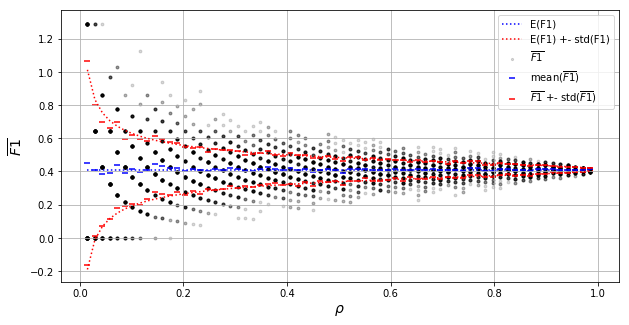

In [226]:
plt.xlabel(r"$\rho$", fontsize = 14)
plt.ylabel(r"$\overline{F1}$", fontsize = 14)
plt.grid(axis='both')
plt.legend()
#plt.ylim([-0.3,1.6])

plt.savefig(address_main +'AVG, STD, GeneratedDataset.png')

plt.show()

# FUNCTIONS

In [145]:
# Linear Function

def g(W,X):
    
    return np.dot(X,w[0,0:-1]) + w[0,-1]

In [146]:
def predicted_labels (df,W):
    N_features = W.shape[1] -1
    for i in range (0 , len(df)):
        Xi = df.iloc[i,0:N_features]
        g_xi = g(W, Xi)
        if g_xi > 0 :
            df.loc[i,'prediction'] = +1
        else:
            df.loc[i,'prediction'] = -1
    return(df['prediction'])

In [147]:
# calculate scores 
def F1_scores(df, writing = False):
    TP = np.sum((df['prediction'] == +1) &  (df ['real_label'] == +1))
    FP = np.sum((df['prediction'] == +1) &  (df ['real_label'] == 0))
    FN = np.sum((df['prediction'] == 0) &  (df ['real_label'] == +1))
    if writing :
        print( 'TP, FP, FN = ', TP, FP, FN)

    pr = TP/(TP+FP)
    re = TP/(TP+FN)
    F_score = 2*pr*re/(pr+re)

    
    return (F_score )

In [148]:
# calculate scores 
def F1_estimate(df,rho, writing = False):
    
    TP_ = np.sum((df['prediction'] == +1) &  (df ['visible_label'] == +1))
    FP_ = np.sum((df['prediction'] == +1) &  (df ['visible_label'] == 0))
    FN_ = np.sum((df['prediction'] == 0) &  (df ['visible_label'] == +1))
    if writing :
        print( 'TP_, FP_, FN_ = ', TP_, FP_, FN_)
    pr_ = TP_/(TP_ + FP_)
    pr_ /= rho
    re_ = TP_/(TP_ + FN_)
    F_score_ = 2*pr_*re_/(pr_+re_)

    if writing:
        print('np.sum((df[prediction] == +1)) = ', np.sum((df['prediction'] == +1)))
    

    if np.isnan(F_score_):
        F_score_=0

    return ( F_score_)

In [152]:

def viz(df_data,address=''):
    size_data = len(df_data)
    c=[]
    alpha= []
    S= 80
    for i in range(0,size_data):
        if df_data.loc[i,'real_label'] == 0 :
            c.append('b')
        else:
            c.append('r')    

        if df_data.loc[i,'visible_label'] == 0 :
            alpha.append(1)
        else:
            alpha.append(8)


    plt.scatter(df_data['x'],df_data['y'], alpha=0.5,linewidths=alpha,edgecolors = 'k', c=c,s=S)
    plt.xlim([0,1])
    plt.ylim([0,1])
    if (address!='') :
        print('saved')
        plt.savefig(address)
    plt.show()



